# Time Series Hyperband Forecasting

Based on:
* [Time Series Forecasting on Stock Prices](https://www.youtube.com/watch?v=j05UUs99eNQ) from [Coding Tech](https://www.youtube.com/channel/UCtxCXg-UvSnTKPOzLH4wJaQ)

Related:
* https://iknowfirst.com/stock-forecast-algorithm

**Disclaimer:** _Investing in the stock market involves risk and can lead to monetary loss. This material is purely for educational purposes and should not be taken as professional investment advice. Invest at your own discretion._

Import the libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.svm import SVR

from sklearn.feature_selection import RFE

import keras_tuner as kt

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

import matplotlib.pyplot as plt

Load the data

In [2]:
df = pd.read_csv("SP500.csv")

Show the data

In [3]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,775500,0.0,0
1,2000-05-22,94.716551,94.716551,92.169162,94.190231,1850600,0.0,0
2,2000-05-23,94.463952,94.463952,92.758675,92.758675,373900,0.0,0
3,2000-05-24,92.800753,94.358660,92.063905,94.148132,400300,0.0,0
4,2000-05-25,94.337613,94.948145,92.884970,93.284973,69600,0.0,0
...,...,...,...,...,...,...,...,...
5359,2021-09-08,452.899994,453.679993,450.869995,453.000000,4076800,0.0,0
5360,2021-09-09,452.690002,454.579987,450.730011,450.980011,3851600,0.0,0
5361,2021-09-10,453.059998,453.510010,447.299988,447.540009,3023500,0.0,0
5362,2021-09-13,450.679993,450.929993,446.089996,448.579987,3007400,0.0,0


Add indices for every day in the period

In [4]:
start_date = df.Date.min()
end_date = df.Date.max()

In [5]:
df_date = pd.date_range(start=start_date, end=end_date).to_frame(name="Date")
df_date.reset_index(drop=True, inplace=True) 

In [6]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.merge(df_date, how='right')

Interpolate missing values

In [7]:
df = df.interpolate(method='linear', limit_direction='both')

In [8]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2000-05-19,96.106028,96.106028,94.484962,94.779701,7.755000e+05,0.0,0.0
1,2000-05-20,95.642869,95.642869,93.713029,94.583211,1.133867e+06,0.0,0.0
2,2000-05-21,95.179710,95.179710,92.941096,94.386721,1.492233e+06,0.0,0.0
3,2000-05-22,94.716551,94.716551,92.169162,94.190231,1.850600e+06,0.0,0.0
4,2000-05-23,94.463952,94.463952,92.758675,92.758675,3.739000e+05,0.0,0.0
...,...,...,...,...,...,...,...,...
7784,2021-09-10,453.059998,453.510010,447.299988,447.540009,3.023500e+06,0.0,0.0
7785,2021-09-11,452.266663,452.650004,446.896657,447.886668,3.018133e+06,0.0,0.0
7786,2021-09-12,451.473328,451.789998,446.493327,448.233327,3.012767e+06,0.0,0.0
7787,2021-09-13,450.679993,450.929993,446.089996,448.579987,3.007400e+06,0.0,0.0


Remove not needed columns

In [9]:
df = df[['Date', 'Close']].copy()

In [10]:
df

,Date,Close
0,2000-05-19,94.779701
1,2000-05-20,94.583211
2,2000-05-21,94.386721
3,2000-05-22,94.190231
4,2000-05-23,92.758675
...,...,...
7784,2021-09-10,447.540009
7785,2021-09-11,447.886668
7786,2021-09-12,448.233327
7787,2021-09-13,448.579987


**Simple Moving Average**
* Example periods: 15, 30 or 45 days

In [11]:
def computeSMA(data, period, column='Close'):
    return data[column].rolling(window=period).mean()

In [12]:
df['SMA'] = computeSMA(df, period=15)

**Exponential Moving Averages**
* Example periods: 15, 30 or 45 days

In [13]:
def computeEMA(data, period, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

In [14]:
df['EMA'] = computeEMA(df, period=15)

**Relative Strength Index**

In [15]:
def computeRSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = computeSMA(data, period, column='up')
    AVG_Loss = abs(computeSMA(data, period, column='down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

In [16]:
df['RSI'] = computeRSI(df, period=14)

**Moving Average Convergence Divergence**

In [17]:
def MACD(data, period1=26, period2=12, signal=9, column='Close'):
    exp1 = computeEMA(data,period1, column=column)
    exp2 = computeEMA(data,period2, column=column)
    data['MACD'] = exp2 - exp1
    data['Signal Line'] = computeSMA(data, signal, column='MACD')

In [18]:
MACD(df)

In [19]:
df

,Date,Close,SMA,EMA,up,down,RSI,MACD,Signal Line
0,2000-05-19,94.779701,NaN,94.779701,NaN,NaN,NaN,0.000000,NaN
1,2000-05-20,94.583211,NaN,94.755140,0.000000,-0.196490,NaN,-0.015674,NaN
2,2000-05-21,94.386721,NaN,94.709088,0.000000,-0.196490,NaN,-0.043451,NaN
3,2000-05-22,94.190231,NaN,94.644231,0.000000,-0.196490,NaN,-0.080392,NaN
4,2000-05-23,92.758675,NaN,94.408536,0.000000,-1.431557,NaN,-0.222617,NaN
...,...,...,...,...,...,...,...,...,...
7784,2021-09-10,447.540009,453.257671,451.878931,0.000000,-3.440002,30.279938,1.487905,2.619024
7785,2021-09-11,447.886668,452.970782,451.379898,0.346659,0.000000,28.313930,1.046934,2.394046
7786,2021-09-12,448.233327,452.662337,450.986577,0.346659,0.000000,26.233827,0.717167,2.129901
7787,2021-09-13,448.579987,452.332335,450.685753,0.346659,0.000000,24.029401,0.478284,1.844411


Remove NaNs

In [20]:
df = df.dropna()

In [21]:
df

,Date,Close,SMA,EMA,up,down,RSI,MACD,Signal Line
14,2000-06-02,99.663971,94.910938,95.600925,1.936874,0.000000,71.245582,0.680463,-0.042866
15,2000-06-03,99.446431,95.222053,96.081613,0.000000,-0.217539,71.115354,0.916439,0.090681
16,2000-06-04,99.228892,95.531765,96.475023,0.000000,-0.217539,70.985601,1.073524,0.250695
17,2000-06-05,99.011353,95.840074,96.792064,0.000000,-0.217539,70.856321,1.167008,0.420929
18,2000-06-06,98.506065,96.127796,97.006314,0.000000,-0.505287,77.029581,1.186644,0.585988
...,...,...,...,...,...,...,...,...,...
7784,2021-09-10,447.540009,453.257671,451.878931,0.000000,-3.440002,30.279938,1.487905,2.619024
7785,2021-09-11,447.886668,452.970782,451.379898,0.346659,0.000000,28.313930,1.046934,2.394046
7786,2021-09-12,448.233327,452.662337,450.986577,0.346659,0.000000,26.233827,0.717167,2.129901
7787,2021-09-13,448.579987,452.332335,450.685753,0.346659,0.000000,24.029401,0.478284,1.844411


Data preparation

In [22]:
in_seq1 = df['SMA'].values
in_seq2 = df['EMA'].values
in_seq3 = df['RSI'].values
in_seq4 = df['MACD'].values
in_seq5 = df['Signal Line'].values
out_seq = df['Close'].values

In [23]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [24]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5))

Scale values

In [25]:
scaler = MinMaxScaler()
scaler.fit(dataset)
dataset = scaler.transform(dataset)

**Dimensionality reduction - PCA**

In [26]:
pca = PCA()
pca.fit(dataset)

PCA()

Transform

In [27]:
dataset_pca = pca.transform(dataset)

**Recursive feature elimination**

In [28]:
estimator = SVR(kernel="linear")

In [29]:
selector = RFE(estimator, step=1)

In [30]:
selector = selector.fit(dataset_pca, out_seq)

/home/vladiant/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/vladiant/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/vladiant/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/vladiant/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

In [31]:
print(f"Selected features: {selector.support_}")

Selected features: [ True  True False False False]


In [32]:
print(f"Features ranking: {selector.ranking_}")

Features ranking: [1 1 3 2 4]


In [33]:
print(f"Score: {selector.score(dataset_pca, out_seq)}")

Score: 0.9993543829868292


In [34]:
dataset = selector.transform(dataset_pca)

In [35]:
dataset = np.hstack((dataset, out_seq))

Choose a number of time steps

In [36]:
n_steps = 10

Separate a multivariate sequence into samples

In [37]:
def split_sequences(sequences, steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # Find the end of the pattern
        end_ix = i + n_steps
        # Check if we are bound by sequence
        if end_ix > len(sequences) - 1:
            break
        # Gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

Convert into input/output

In [38]:
X, y = split_sequences(dataset, n_steps)

The dataset knows the number of the features, e.g. 2

In [39]:
n_features = X.shape[2]

Set test data

In [40]:
test_size = n_steps
prediction_size = n_features
y_test = y[-test_size-prediction_size:-prediction_size]
X_test = X[-test_size-prediction_size:-prediction_size]

In [41]:
y_expected = y[-prediction_size:]

In [42]:
y = y[:-test_size-prediction_size]
X = X[:-test_size-prediction_size]

**Define model**

Keras Random Search - optimize: LSTM units, Dropout Rate, Learning Rate, Sequence Length

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [43]:
def model_builder(hp):
    model = Sequential()
    
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=250, step=10)
    model.add(LSTM(hp_units_1, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    
    dropout_rate_1 = hp.Float('dropout_1', 0, 0.9, step=0.1, default=0.5)
    model.add(Dropout(dropout_rate_1))
    
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=250, step=10)
    model.add(LSTM(hp_units_2, activation='relu'))
    
    dropout_rate_2 = hp.Float('dropout_2', 0, 0.9, step=0.1, default=0.5)
    model.add(Dropout(dropout_rate_2))
    
    model.add(Dense(n_features))
    
    model.compile(optimizer='adam', loss='mse')
    
    return model    

In [44]:
tuner = kt.Hyperband(model_builder,
                     objective='loss',
                     max_epochs=10,
                     factor=3,
                     directory='ts_test_dir',
                     project_name='ts_forecast_tune')

In [45]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [46]:
tuner.search(X, y, epochs=100, callbacks=[stop_early])

Trial 30 Complete [00h 00m 45s]
loss: 1756.3858642578125

Best loss So Far: 168.2464141845703
Total elapsed time: 00h 10m 40s
INFO:tensorflow:Oracle triggered exit


Get the optimal hyperparameters

In [47]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [48]:
print(f"The optimal number of LSTM units are {best_hps.get('units_1')} and {best_hps.get('units_2')} ")
print(f"The dropouts are {best_hps.get('dropout_1')} and {best_hps.get('dropout_2')}")

The optimal number of LSTM units are 40 and 240 
The dropouts are 0.30000000000000004 and 0.1


Build the model with the optimal hyperparameters and train it on the data for 50 epochs

In [49]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X, y, epochs=300)

Epoch 1/300
243/243 [==============================] - 4s 16ms/step - loss: 3611.4915
Epoch 2/300
243/243 [==============================] - 4s 18ms/step - loss: 248.3199
Epoch 3/300
243/243 [==============================] - 5s 22ms/step - loss: 181.8274
Epoch 4/300
243/243 [==============================] - 5s 22ms/step - loss: 206.0918
Epoch 5/300
243/243 [==============================] - 5s 22ms/step - loss: 170.2121
Epoch 6/300
243/243 [==============================] - 5s 22ms/step - loss: 187.6500
Epoch 7/300
243/243 [==============================] - 5s 22ms/step - loss: 269.9380
Epoch 8/300
243/243 [==============================] - 5s 22ms/step - loss: 150.8417
Epoch 9/300
243/243 [==============================] - 5s 22ms/step - loss: 167.8600
Epoch 10/300
243/243 [==============================] - 5s 22ms/step - loss: 181.5167
Epoch 11/300
243/243 [==============================] - 5s 22ms/step - loss: 170.4916
Epoch 12/300
243/243 [==============================] - 5s 22m

243/243 [==============================] - 5s 19ms/step - loss: 59.7574
Epoch 98/300
243/243 [==============================] - 5s 19ms/step - loss: 58.6595
Epoch 99/300
243/243 [==============================] - 5s 19ms/step - loss: 57.2564
Epoch 100/300
243/243 [==============================] - 4s 18ms/step - loss: 53.6202
Epoch 101/300
243/243 [==============================] - 4s 18ms/step - loss: 57.1547
Epoch 102/300
243/243 [==============================] - 4s 17ms/step - loss: 54.4352
Epoch 103/300
243/243 [==============================] - 4s 18ms/step - loss: 57.5089
Epoch 104/300
243/243 [==============================] - 6s 24ms/step - loss: 80.2439
Epoch 105/300
243/243 [==============================] - 6s 24ms/step - loss: 86.4679
Epoch 106/300
243/243 [==============================] - 6s 24ms/step - loss: 69.6967
Epoch 107/300
243/243 [==============================] - 6s 24ms/step - loss: 63.9534
Epoch 108/300
243/243 [==============================] - 6s 24ms/step 

243/243 [==============================] - 5s 20ms/step - loss: 50.1560
Epoch 193/300
243/243 [==============================] - 5s 20ms/step - loss: 51.9573
Epoch 194/300
243/243 [==============================] - 5s 20ms/step - loss: 51.9879
Epoch 195/300
243/243 [==============================] - 4s 18ms/step - loss: 50.7745
Epoch 196/300
243/243 [==============================] - 4s 18ms/step - loss: 48.7822
Epoch 197/300
243/243 [==============================] - 6s 26ms/step - loss: 49.9341
Epoch 198/300
243/243 [==============================] - 6s 25ms/step - loss: 46.6622
Epoch 199/300
243/243 [==============================] - 6s 25ms/step - loss: 50.3481
Epoch 200/300
243/243 [==============================] - 6s 25ms/step - loss: 47.1871
Epoch 201/300
243/243 [==============================] - 6s 26ms/step - loss: 49.4234
Epoch 202/300
243/243 [==============================] - 6s 26ms/step - loss: 51.1861
Epoch 203/300
243/243 [==============================] - 6s 25ms/ste

243/243 [==============================] - 4s 15ms/step - loss: 56.9442
Epoch 288/300
243/243 [==============================] - 5s 21ms/step - loss: 51.0956
Epoch 289/300
243/243 [==============================] - 5s 21ms/step - loss: 50.7371
Epoch 290/300
243/243 [==============================] - 5s 21ms/step - loss: 51.2108
Epoch 291/300
243/243 [==============================] - 5s 21ms/step - loss: 47.2180
Epoch 292/300
243/243 [==============================] - 5s 21ms/step - loss: 52.2575
Epoch 293/300
243/243 [==============================] - 5s 21ms/step - loss: 48.6886
Epoch 294/300
243/243 [==============================] - 5s 21ms/step - loss: 48.9135
Epoch 295/300
243/243 [==============================] - 5s 21ms/step - loss: 46.0997
Epoch 296/300
243/243 [==============================] - 5s 21ms/step - loss: 50.4784
Epoch 297/300
243/243 [==============================] - 5s 21ms/step - loss: 47.3292
Epoch 298/300
243/243 [==============================] - 5s 21ms/ste

In [50]:
loss_per_epoch = history.history['loss']
best_epoch = loss_per_epoch.index(min(loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 282


Retrain the model

In [51]:
model = tuner.hypermodel.build(best_hps)

In [52]:
model.fit(X, y, epochs=best_epoch)

Epoch 1/282
243/243 [==============================] - 5s 22ms/step - loss: 4083.0854
Epoch 2/282
243/243 [==============================] - 5s 21ms/step - loss: 255.1636
Epoch 3/282
243/243 [==============================] - 5s 21ms/step - loss: 215.9391
Epoch 4/282
243/243 [==============================] - 5s 21ms/step - loss: 176.0590
Epoch 5/282
243/243 [==============================] - 5s 21ms/step - loss: 184.4689
Epoch 6/282
243/243 [==============================] - 4s 17ms/step - loss: 189.3852
Epoch 7/282
243/243 [==============================] - 6s 23ms/step - loss: 187.5283
Epoch 8/282
243/243 [==============================] - 7s 27ms/step - loss: 180.2393
Epoch 9/282
243/243 [==============================] - 7s 27ms/step - loss: 166.5152
Epoch 10/282
243/243 [==============================] - 6s 26ms/step - loss: 167.6424
Epoch 11/282
243/243 [==============================] - 6s 27ms/step - loss: 159.3664
Epoch 12/282
243/243 [==============================] - 7s 27m

243/243 [==============================] - 8s 33ms/step - loss: 57.7514
Epoch 98/282
243/243 [==============================] - 8s 32ms/step - loss: 64.8717
Epoch 99/282
243/243 [==============================] - 8s 32ms/step - loss: 58.5783
Epoch 100/282
243/243 [==============================] - 8s 32ms/step - loss: 60.2837
Epoch 101/282
243/243 [==============================] - 8s 31ms/step - loss: 70.6392
Epoch 102/282
243/243 [==============================] - 7s 30ms/step - loss: 61.9375
Epoch 103/282
243/243 [==============================] - 5s 20ms/step - loss: 58.6554
Epoch 104/282
243/243 [==============================] - 5s 22ms/step - loss: 59.3056
Epoch 105/282
243/243 [==============================] - 6s 24ms/step - loss: 57.9287
Epoch 106/282
243/243 [==============================] - 6s 23ms/step - loss: 57.9622
Epoch 107/282
243/243 [==============================] - 6s 23ms/step - loss: 69.9938
Epoch 108/282
243/243 [==============================] - 6s 24ms/step 

243/243 [==============================] - 6s 23ms/step - loss: 55.5200
Epoch 193/282
243/243 [==============================] - 6s 25ms/step - loss: 54.1491
Epoch 194/282
243/243 [==============================] - 6s 24ms/step - loss: 55.9494
Epoch 195/282
243/243 [==============================] - 6s 23ms/step - loss: 54.0143
Epoch 196/282
243/243 [==============================] - 6s 24ms/step - loss: 54.5349
Epoch 197/282
243/243 [==============================] - 6s 23ms/step - loss: 57.9223
Epoch 198/282
243/243 [==============================] - 5s 20ms/step - loss: 55.8227
Epoch 199/282
243/243 [==============================] - 4s 18ms/step - loss: 58.7054
Epoch 200/282
243/243 [==============================] - 6s 23ms/step - loss: 55.4508
Epoch 201/282
243/243 [==============================] - 5s 22ms/step - loss: 56.3625
Epoch 202/282
243/243 [==============================] - 6s 24ms/step - loss: 52.2014
Epoch 203/282
243/243 [==============================] - 5s 22ms/ste

Demonstrate training

In [53]:
yhat = model.predict(X)

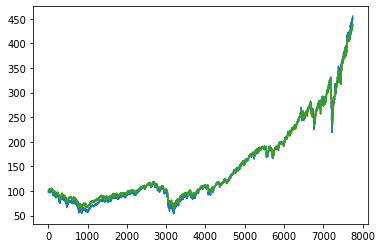

In [54]:
plt.plot(y)
plt.plot(yhat)
plt.show()

Demonstrate prediction

In [55]:
yhat = model.predict(X_test)

In [56]:
print(f"Predicted: {yhat[0][0]:.2f}  Expected: {y_expected[0]:.2f}")

Predicted: 441.24  Expected: 448.58


**THIS IS NOT AN INVESTMENT ADVICE!**